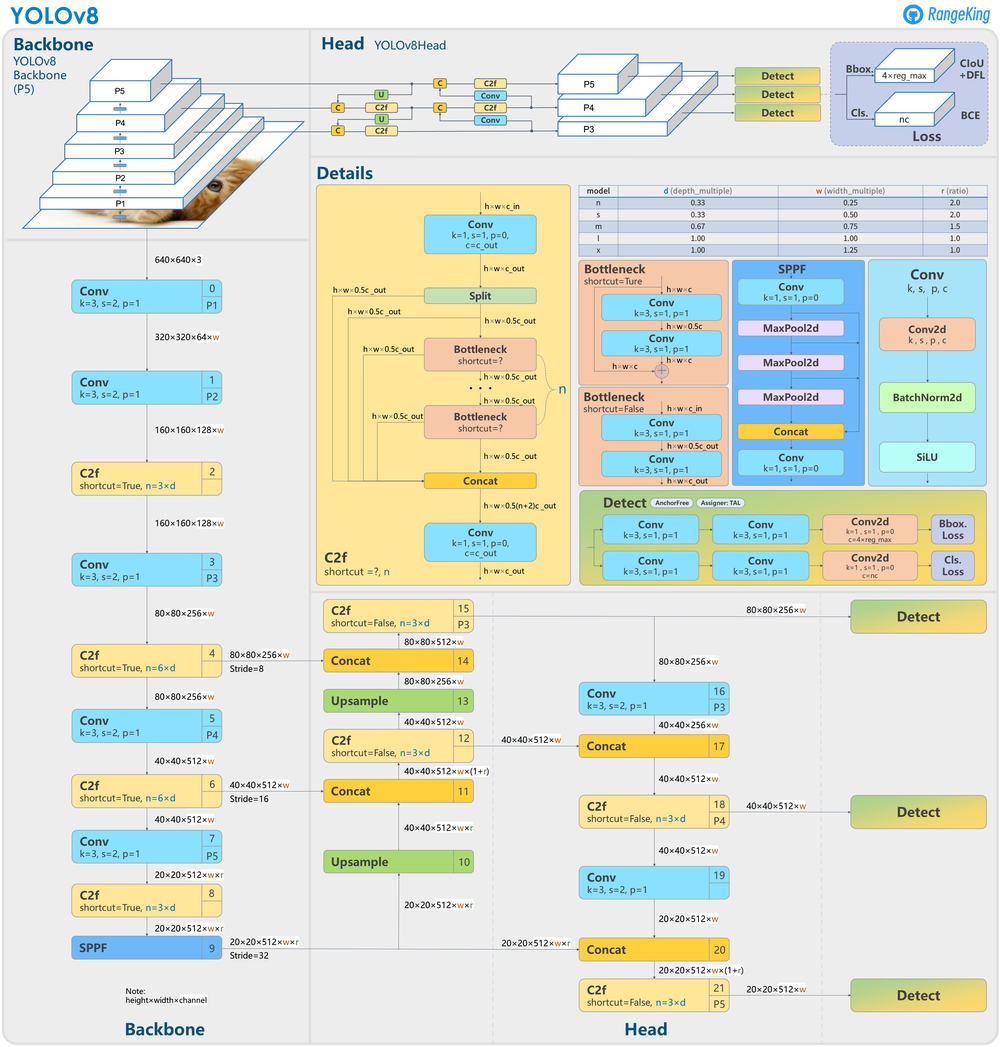


In [1]:
!pip install --quiet imutils
!pip install --quiet wget
!pip install --quiet split-folders
!pip install --quiet ultralytics

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.8/699.8 kB 7.7 MB/s eta 0:00:00


In [2]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [3]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import numpy as np
import os
import wget
from PIL import Image
import cv2
import requests
import tarfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [4]:
def download_and_extract(url, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get the filename from the URL
    filename = os.path.join(destination_folder, url.split("/")[-1])

    # Download the file
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

    # Extract the contents of the tar.gz file
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall(destination_folder)

    # Remove the downloaded compressed file
    os.remove(filename)

In [5]:
dataset_url = "http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz"

destination_folder = "flickr_logos_dataset"

download_and_extract(dataset_url, destination_folder)



In [6]:
fname = '/content/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

with tarfile.open(fname, 'r:gz') as tar:
    tar.extractall(destination_folder)

os.remove(fname)

In [7]:
txt_path = "/content/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"

In [8]:
df = pd.read_csv(txt_path,
                 sep='\s+',
                 header=None)

In [9]:
df.shape

(4536, 7)

In [10]:
columns = ['filename', 'class', 'sub-class','xmin', 'ymin', 'xmax', 'ymax']


In [11]:
df.columns = columns

In [12]:
df.head(5)

,filename,class,sub-class,xmin,ymin,xmax,ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [13]:
classes = df['class'].unique().tolist()

In [14]:
print("Classess = ",classes)
print("\n\nTotal Classess = ",len(classes))

Classess =  ['Adidas' 'Apple' 'BMW' 'Citroen' 'Cocacola' 'DHL' 'Fedex' 'Ferrari' 'Ford' 'Google' 'Heineken' 'HP' 'Intel' 'McDonalds' 'Mini' 'Nbc' 'Nike' 'Pepsi' 'Porsche' 'Puma' 'RedBull' 'Sprite' 'Starbucks' 'Texaco' 'Unicef' 'Vodafone' 'Yahoo']


Total Classess =  27


In [15]:
class_mapping = {class_name: i for i, class_name in enumerate(classess)}

for class_name, class_no in class_mapping.items():
    print(f"{class_name}: {class_no}")

Adidas: 0
Apple: 1
BMW: 2
Citroen: 3
Cocacola: 4
DHL: 5
Fedex: 6
Ferrari: 7
Ford: 8
Google: 9
Heineken: 10
HP: 11
Intel: 12
McDonalds: 13
Mini: 14
Nbc: 15
Nike: 16
Pepsi: 17
Porsche: 18
Puma: 19
RedBull: 20
Sprite: 21
Starbucks: 22
Texaco: 23
Unicef: 24
Vodafone: 25
Yahoo: 26


In [16]:
def is_valid_image(img_path):
    try:
        Image.open(img_path).verify()
        return True
    except (IOError, SyntaxError):
        return False

def remove_broken_and_invalid_entries(folder_path, annotation_file_path):

    total_images_before = len(os.listdir(folder_path))

    with open(annotation_file_path, 'r') as file:
        total_entries_before = len(file.readlines())

    # Read the annotation file into a list
    with open(annotation_file_path, 'r') as file:
        annotations = file.readlines()

    # Filter out broken and invalid entries
    valid_annotations = []
    for annotation in annotations:
        parts = annotation.split()
        img_name, class_name, _, xmin, ymin, xmax, ymax = parts

        # Check if image is valid
        img_path = os.path.join(folder_path, img_name)
        if not is_valid_image(img_path):
            continue

        # Check if bounding box is valid
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        if xmin >= xmax or ymin >= ymax:
            continue

        # If both checks pass, add the annotation to the valid list
        valid_annotations.append(annotation)

    # Update the annotation file
    with open(annotation_file_path, 'w') as file:
        file.writelines(valid_annotations)

    # Remove broken and invalid images
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            img_path = os.path.join(root, file)
            if not is_valid_image(img_path):
                os.remove(img_path)
            else:
                img_name = file
                annotation_exists = any(img_name in annotation for annotation in valid_annotations)
                if not annotation_exists:
                    print(img_path)
                    os.remove(img_path)

    # Count the total number of images after removal
    total_images_after = len(os.listdir(folder_path))

    total_entries_after = len(valid_annotations)

    print(f"Total number of entries before: {total_entries_before}")
    print(f"Total number of entries after Removal: {total_entries_after}")

    print(f"Total number of images before Removal: {total_images_before}")
    print(f"Total number of images after Removal: {total_images_after}")

In [17]:
folder_path = "/content/flickr_logos_dataset/flickr_logos_27_dataset_images"
annotation_file_path = "/content/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
remove_broken_and_invalid_entries(folder_path, annotation_file_path)

/content/flickr_logos_dataset/flickr_logos_27_dataset_images/4288066623.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/556390286.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/6651198.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/4273898682.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/3074038845.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/3394979299.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/3753448903.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/322344318.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/3367600894.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/3218175983.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/3007900027.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/4498492208.jpg
/content/flickr_logos_dataset/flickr_logos_27_dataset_images/2553484499.jpg
/content/flickr_l

In [18]:
df = pd.read_csv("/content/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt",
                 sep='\s+',
                 header=None)
df.shape

(4531, 7)

In [23]:
df.columns = columns

In [24]:
df.head(5)

,filename,class,sub-class,xmin,ymin,xmax,ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [25]:
ANNOTATION_FILE_PATH = '/kaggle/working/flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt'
IMAGES_FOLDER_PATH = '/content/flickr_logos_dataset/flickr_logos_27_dataset_images'
OUTPUT_FOLDER_PATH = 'LOGOS'

In [26]:
# Create folders
output_images_folder = os.path.join(OUTPUT_FOLDER_PATH, 'images')
output_labels_folder = os.path.join(OUTPUT_FOLDER_PATH, 'labels')
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

In [27]:
for idx, row in df.iterrows():
    filename = row['filename']
    class_name = row['class']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Read image
    image_path = os.path.join(IMAGES_FOLDER_PATH, filename)
    image = Image.open(image_path).convert("RGB")
    image_w, image_h = image.size

    # Calculate normalized bounding box coordinates
    b_center_x = (xmin + xmax) / 2
    b_center_y = (ymin + ymax) / 2
    b_width = (xmax - xmin)
    b_height = (ymax - ymin)

    b_center_x /= image_w
    b_center_y /= image_h
    b_width /= image_w
    b_height /= image_h

    # Save image
    output_image_path = os.path.join(output_images_folder, filename)
    image.save(output_image_path)

    # Save label file
    label_filename = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(output_labels_folder, label_filename)
    with open(label_path, 'w') as label_file:
        class_id = class_mapping[class_name]
        label_file.write(f"{class_id} {b_center_x} {b_center_y} {b_width} {b_height}")

print("Processing complete.")

Processing complete.


In [33]:
label_path = '/content/LOGOS/labels/1075391489.txt'
img = '/content/LOGOS/images/1075391489.jpg'
image = cv2.imread(img)

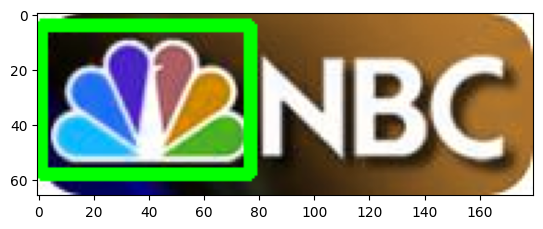

In [37]:
with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        for label in labels:
          class_id, x_center, y_center, width, height = map(float, label.split())
          x_min = int((x_center - width/2) * image.shape[1])
          y_min = int((y_center - height/2) * image.shape[0])
          x_max = int((x_center + width/2) * image.shape[1])
          y_max = int((y_center + height/2) * image.shape[0])
          cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
          plt.imshow(image)

In [38]:
splitfolders.ratio('/content/LOGOS', output="data", seed=42, ratio=(0.8,0.2))


Copying files: 1616 files [00:00, 8164.52 files/s]


In [39]:
from ultralytics import YOLO

In [75]:
model = YOLO("yolov8n.pt")
dict_classes = model.model.names

In [76]:
dict_classes

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [77]:
import yaml

In [61]:
data = {'train' :  '/content/data/train',
        'val' :  '/content/data/val',
        'test' :  '/content/data/val',
        'nc': len(classes),
        'names': classes
        }

In [62]:
file_path = 'data.yaml'
with open(file_path, 'w') as f:
    yaml.dump(data, f)

In [63]:
# read the content in .yaml file
with open('/content/data.yaml', 'r') as f:
    hamster_yaml = yaml.safe_load(f)
    display(hamster_yaml)

{'names': ['Adidas',
  'Apple',
  'BMW',
  'Citroen',
  'Cocacola',
  'DHL',
  'Fedex',
  'Ferrari',
  'Ford',
  'Google',
  'Heineken',
  'HP',
  'Intel',
  'McDonalds',
  'Mini',
  'Nbc',
  'Nike',
  'Pepsi',
  'Porsche',
  'Puma',
  'RedBull',
  'Sprite',
  'Starbucks',
  'Texaco',
  'Unicef',
  'Vodafone',
  'Yahoo'],
 'nc': 27,
 'test': '/content/data/val',
 'train': '/content/data/train',
 'val': '/content/data/val'}

In [64]:
print(len(model.names)) # 80 COCO dataset labels

80


In [65]:
data_path = '/content/data.yaml'

In [66]:
model.train(data=data_path, epochs=10, batch=8)

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/data.yaml, epochs=10, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]

Overriding model.yaml nc=80 with nc=27

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 6.23M/6.23M [00:00<00:00, 110MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/data/train/labels... 646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 646/646 [00:00<00:00, 1892.15it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val/labels... 162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:00<00:00, 948.29it/s] 

val: New cache created: /content/data/val/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000323, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.09G      1.554      5.709      1.941          6        640: 100%|██████████| 81/81 [00:53<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

                   all        162        162      0.439      0.217      0.235      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.44G      1.493      4.262      1.829          5        640: 100%|██████████| 81/81 [00:54<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

                   all        162        162      0.789      0.195      0.252      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      7.38G      1.513      3.825      1.844          6        640: 100%|██████████| 81/81 [00:57<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]

                   all        162        162      0.538       0.26      0.271      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       7.4G      1.568      3.387      1.864          6        640: 100%|██████████| 81/81 [00:57<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

                   all        162        162       0.41      0.348      0.309      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.42G      1.538      3.087      1.856          6        640: 100%|██████████| 81/81 [00:56<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]

                   all        162        162      0.542      0.331      0.336      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.38G      1.432      2.889      1.741          6        640: 100%|██████████| 81/81 [00:57<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.65it/s]

                   all        162        162      0.356      0.416      0.368      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.38G      1.398      2.509      1.732          6        640: 100%|██████████| 81/81 [00:56<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.65it/s]

                   all        162        162      0.519      0.343      0.414      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.38G      1.321       2.25      1.663          6        640: 100%|██████████| 81/81 [00:56<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

                   all        162        162      0.447      0.497      0.531      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.46G      1.283      1.982      1.634          6        640: 100%|██████████| 81/81 [00:56<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

                   all        162        162      0.649      0.465      0.567      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      7.47G       1.17      1.679      1.533          6        640: 100%|██████████| 81/81 [00:56<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]

                   all        162        162      0.551      0.594      0.611      0.413



10 epochs completed in 0.202 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 136.7MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68149569 parameters, 0 gradients, 257.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


                   all        162        162      0.608      0.563      0.611      0.412
                Adidas        162          7      0.731      0.397      0.419      0.286
                 Apple        162          9      0.289     0.0963      0.314      0.188
                   BMW        162          7      0.531      0.286      0.435      0.268
               Citroen        162          7      0.623      0.429      0.549      0.353
              Cocacola        162          5      0.827        0.4      0.525       0.36
                   DHL        162          6      0.495        0.5      0.659      0.346
                 Fedex        162          4      0.672          1      0.995      0.598
               Ferrari        162         11      0.595      0.636      0.616      0.431
                  Ford        162         10          1      0.609      0.928      0.659
                Google        162          7      0.881      0.714      0.722      0.508
              Heineke

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fdd9e891c90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [71]:
def predict(src):
  result_predict = model.predict(source = src)
  plot = result_predict[0].plot()
  plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(plot))



image 1/1 /content/data/val/images/1690276845.jpg: 480x640 1 Porsche, 74.4ms
Speed: 2.8ms preprocess, 74.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


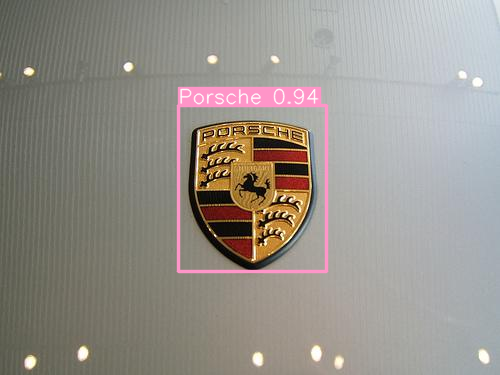

In [74]:
path = '/content/data/val/images/1690276845.jpg'
predict(path)


image 1/1 /content/data/val/images/2126991906.jpg: 192x640 1 Yahoo, 137.3ms
Speed: 1.6ms preprocess, 137.3ms inference, 2.1ms postprocess per image at shape (1, 3, 192, 640)


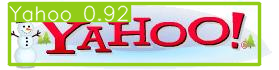

In [72]:
path = '/content/data/val/images/2126991906.jpg'
predict(path)